# Inv. Rendering Example

In [5]:
import irtk
from irtk.scene import *
from irtk.renderer import Renderer
from irtk.io import write_image, to_srgb
from irtk.loss import l1_loss

import matplotlib.pyplot as plt
import imageio
from skimage import img_as_ubyte

from IPython.display import Image, display
from pathlib import Path 

data_path = Path('../data')

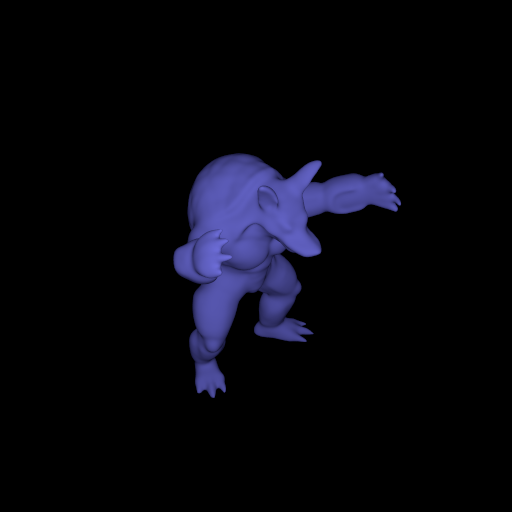

In [30]:
sensor_pos_ref = to_torch_f((-1.5, 1.5, 1.5))

# Define reference scene
scene = Scene()
scene.set('armadillo', Mesh.from_file(data_path / 'meshes' / 'armadillo.obj', mat_id='blue'))
scene.set('blue', DiffuseBRDF((0.2, 0.2, 0.9)))
scene.set('sensor', PerspectiveCamera.from_lookat(fov=40, origin=sensor_pos_ref, target=(0, 0, 0), up=(0, 1, 0)))
scene.set('film', HDRFilm(width=512, height=512))

# Backend-specific component
scene.set('integrator', Integrator(type='collocated', config={
        'intensity': 10
}))

render = Renderer('psdr_jit', render_options={
    'spp': 128,
    'sppe': 0,
    'sppse': 0,
    'log_level': 0,
    'npass': 1
})
image_ref = render(scene)[0]
write_image('image_ref.png', image_ref)
display(Image('image_ref.png'))

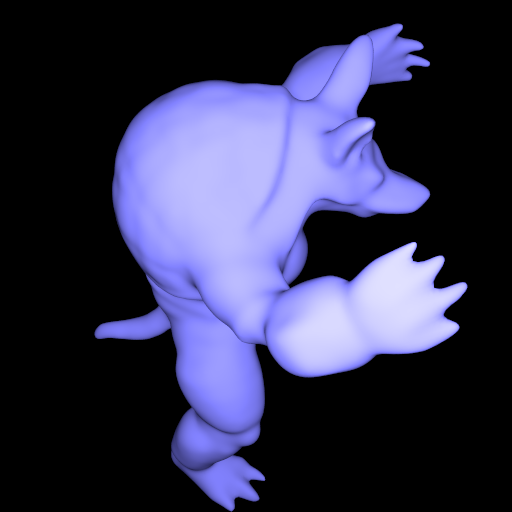

In [35]:
# Switch to initial scene
sensor_pos_init = to_torch_f((-1, 1, 0))
scene.set('sensor', PerspectiveCamera.from_lookat(fov=40, origin=sensor_pos_init, target=(0, 0, 0), up=(0, 1, 0)))
image_init = render(scene)[0]
write_image('image_init.png', image_init)
display(Image('image_init.png'))

Iter 0/100, img loss: 0.2379, param error: 2.7500
Iter 10/100, img loss: 0.0601, param error: 1.5501
Iter 20/100, img loss: 0.0241, param error: 0.8342
Iter 30/100, img loss: 0.0127, param error: 0.4534
Iter 40/100, img loss: 0.0071, param error: 0.2326
Iter 50/100, img loss: 0.0050, param error: 0.1207
Iter 60/100, img loss: 0.0046, param error: 0.0764
Iter 70/100, img loss: 0.0043, param error: 0.0568
Iter 80/100, img loss: 0.0039, param error: 0.0437
Iter 90/100, img loss: 0.0035, param error: 0.0326
Iter 100/100, loss: 0.0029, param error: 0.0215


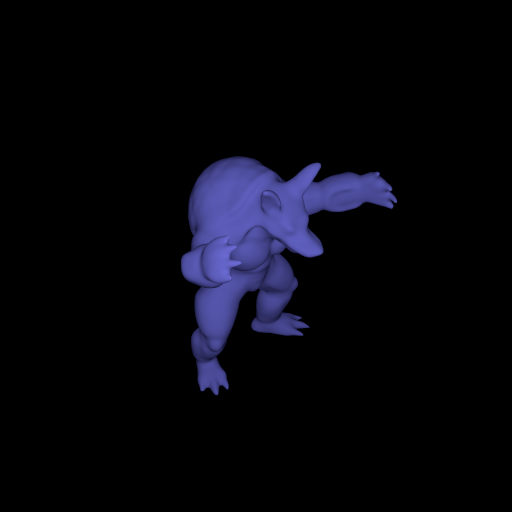

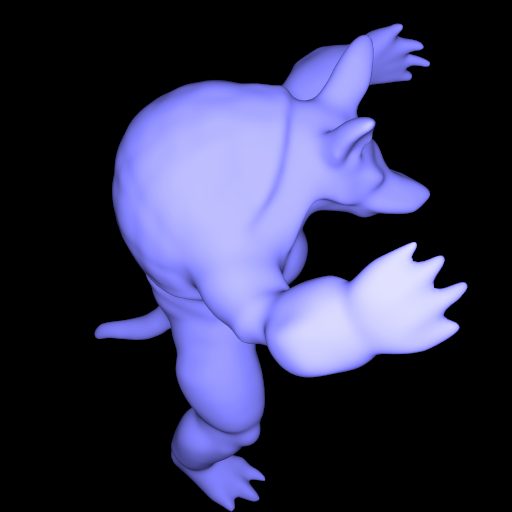

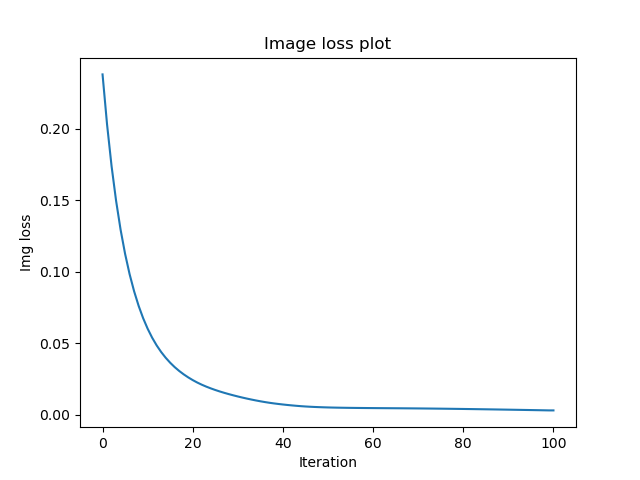

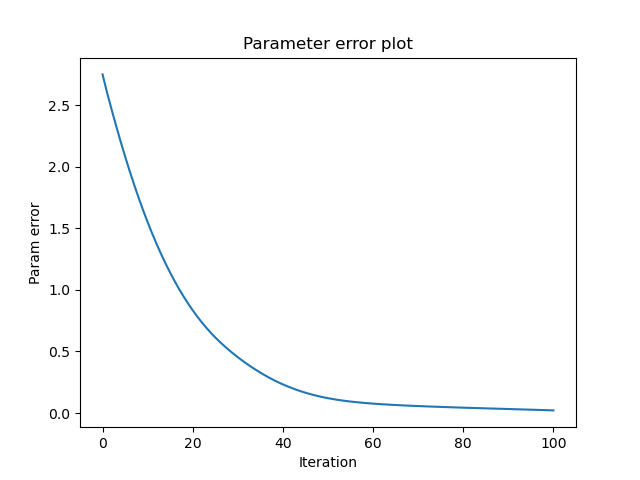

In [38]:
# Optimize camera position
sensor_pos = sensor_pos_init.clone()
sensor_pos.requires_grad_()

num_iter = 100
optimizer = torch.optim.Adam([sensor_pos], lr=0.03)

gif_writer = imageio.get_writer('image_opt.gif', mode='I', duration=30, loop=0)
losses = []
errors = []
for i in range(num_iter):
    optimizer.zero_grad()
    scene['sensor.to_world'] = lookat(origin=sensor_pos, target=(0, 0, 0), up=(0, 1, 0))
    scene.configure()
    
    image_opt = render(scene)[0]
    image_gif = img_as_ubyte(to_srgb(image_opt))
    gif_writer.append_data(image_gif)
    
    loss = l1_loss(image_ref, image_opt)
    loss.backward()
    losses.append(loss.detach().cpu().item())
    error = (sensor_pos - sensor_pos_ref).square().sum().item()
    errors.append(error)
    
    if i % 10 == 0:
        print(f'Iter {i}/{num_iter}, img loss: {loss.detach().cpu():.4f}, param error: {error:.4f}')
    
    optimizer.step()

sensor_pos.requires_grad_(False)
scene.configure()
image_opt = render(scene)[0]
image_gif = img_as_ubyte(to_srgb(image_opt))
gif_writer.append_data(image_gif)
loss = l1_loss(image_ref, image_opt)
losses.append(loss.cpu().item())
error = (sensor_pos - sensor_pos_ref).square().sum().item()
errors.append(error)
print(f'Iter {num_iter}/{num_iter}, loss: {loss.cpu().item():.4f}, param error: {error:.4f}')

write_image('image_opt.png', image_opt)
gif_writer.close()

display(Image('image_opt.png'))
display(Image('image_opt.gif'))

plt.plot(losses, label='img_loss')
plt.xlabel('Iteration'); plt.ylabel('Img loss'); plt.title('Image loss plot')
plt.savefig('loss.png')
plt.close()
display(Image('loss.png'))

plt.plot(errors, label='param_error')
plt.xlabel('Iteration'); plt.ylabel('Param error'); plt.title('Parameter error plot')
plt.savefig('error.png')
plt.close()
display(Image('error.png'))